# Solve a trajectory optimisation problem with bounds and obstacles

In this example, we consider trajectory optimisation with infeasible regions - that is, we want to find a continuous path from an initial point to a target point, while avoiding obstacles in the way and staying within a well-defined region. 

To accomplish this, we chop up the path into discrete intervals and directly optimise over the intermediate values, placing inequality constraints on these intermediate values. The intermediate values we optimise over are called shooting nodes, and the method we use here is called [multiple shooting](https://en.wikipedia.org/wiki/Direct_multiple_shooting_method).

(Note: multiple shooting is a term that is used both in the numerical differential equations literature and in the control literature, the common principle is that the ODE is split into segments, but in control problems the goal of the optimisation is different - to solve an ODE with boundary values on both ends, it is simply an efficient method to accomplish this goal)


Our path can still be described by an ODE, but we now have inequality constraints on the state variables. 
To account for these, we need to unroll the dynamics and directly optimise over the value of the states at discrete time points. To make sure that our pieced-together ODE solution stays smooth, we're adding continuity constraints to our system.

To properly account for inequality constraints on the state variables, we need to unroll the dynamics and optimise over the value of the states at discrete time points. But we still want the trajectory to be continuous, so we are putting an ODE into our constraint function - solved step-wise using a [Diffrax](https://github.com/patrick-kidger/diffrax) ODE solver.

The ODE we're interested in is a system of four first-order ODEs, constructed from a system of two second-order ODEs. It is linear and time-invariant (LTI). We can describe the system's dynamics with

$$\dot{x} = Ax + Bu$$

where $x \in \mathbb{R}^4$ and $u$ \in \mathbb{R}^2$.

First, import everything we need

In [1]:
import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jaxtyping import Array

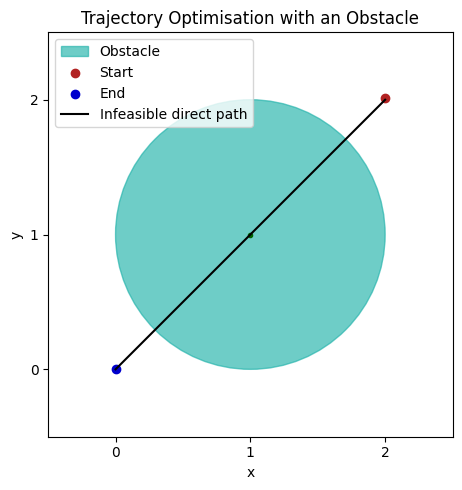

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Add constraint: circle centered at the origin
circle = plt.Circle(
    (1, 1), 1, color="lightseagreen", fill=True, label="Obstacle", alpha=0.65
)
ax.add_patch(circle)
ax.scatter(1, 1, color="darkgreen", marker=".")

ax.scatter(2, 2.01, label="Start", color="firebrick")
ax.scatter(0, 0, label="End", color="mediumblue")

trajectory = jnp.array([[0.0, 0.0], [2.0, 2.0]])
ax.plot([0, 2], [0, 2], color="black", label="Infeasible direct path")

limits = (-0.5, 2.5)
ticks = [0, 1, 2]
ax.set_xlim(*limits)
ax.set_ylim(*limits)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect("equal")
ax.legend(loc="upper left")

ax.set_title("Trajectory Optimisation with an Obstacle")

fig.tight_layout()

In [3]:
class A(eqx.Module):
    b: int

    @eqx.filter_jit
    def __call__(self, x):
        return self.b * x


a = A(2)

a(1)

2

Now we're setting up the system

In [4]:
class LTI(eqx.Module):
    A: Array
    B: Array


A = jnp.array([[1, 1, 0, 0], [0, 1, 0, 0], [0, 0, 1, 1], [0, 0, 0, 1]])
B = jnp.array([[0, 0], [1, 0], [0, 0], [0, 1]])

lti = LTI(A, B)